# Problem 3 - (a)

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### define a dictionay of column name

In [2]:
label_dic = {
    0: 'cylinders', 
    1: 'displacement', 
    2: 'horsepower', 
    3: 'weight', 
    4: 'acceleration', 
    5: 'year made',
    6: 'w0'
}

### read data from csv

In [3]:
data_dir = 'hw1-data/'
X_train = pd.read_csv(data_dir + 'X_train.csv', header=None, names=label_dic.values())
X_test = pd.read_csv(data_dir + 'X_test.csv', header=None, names=label_dic.values())
y_train = pd.read_csv(data_dir + 'y_train.csv', header=None)
y_test = pd.read_csv(data_dir + 'y_test.csv', header=None)

### calculate wRR

In [4]:
dim = X_train.shape[1]
wRR = []
X = X_train.values
for lamb in range(5001):
    lambI = np.diag(np.ones(dim) * lamb)
    inv = np.linalg.inv(lambI + X.T.dot(X))
    wRR.append(inv.dot(X.T).dot(y_train.values).T[0])
wRR = np.array(wRR)

### SVD decomposition

In [5]:
u, d, vT = np.linalg.svd(X)

### calculate df (degree of freedom) of lamba

In [6]:
df_lamb = np.zeros(5001)
for lamb in range(5001):
    df_lamb[lamb] = sum((d[c] ** 2) / (d[c] ** 2 + lamb) for c in range(7))

### plot wRR versus df(lambda)

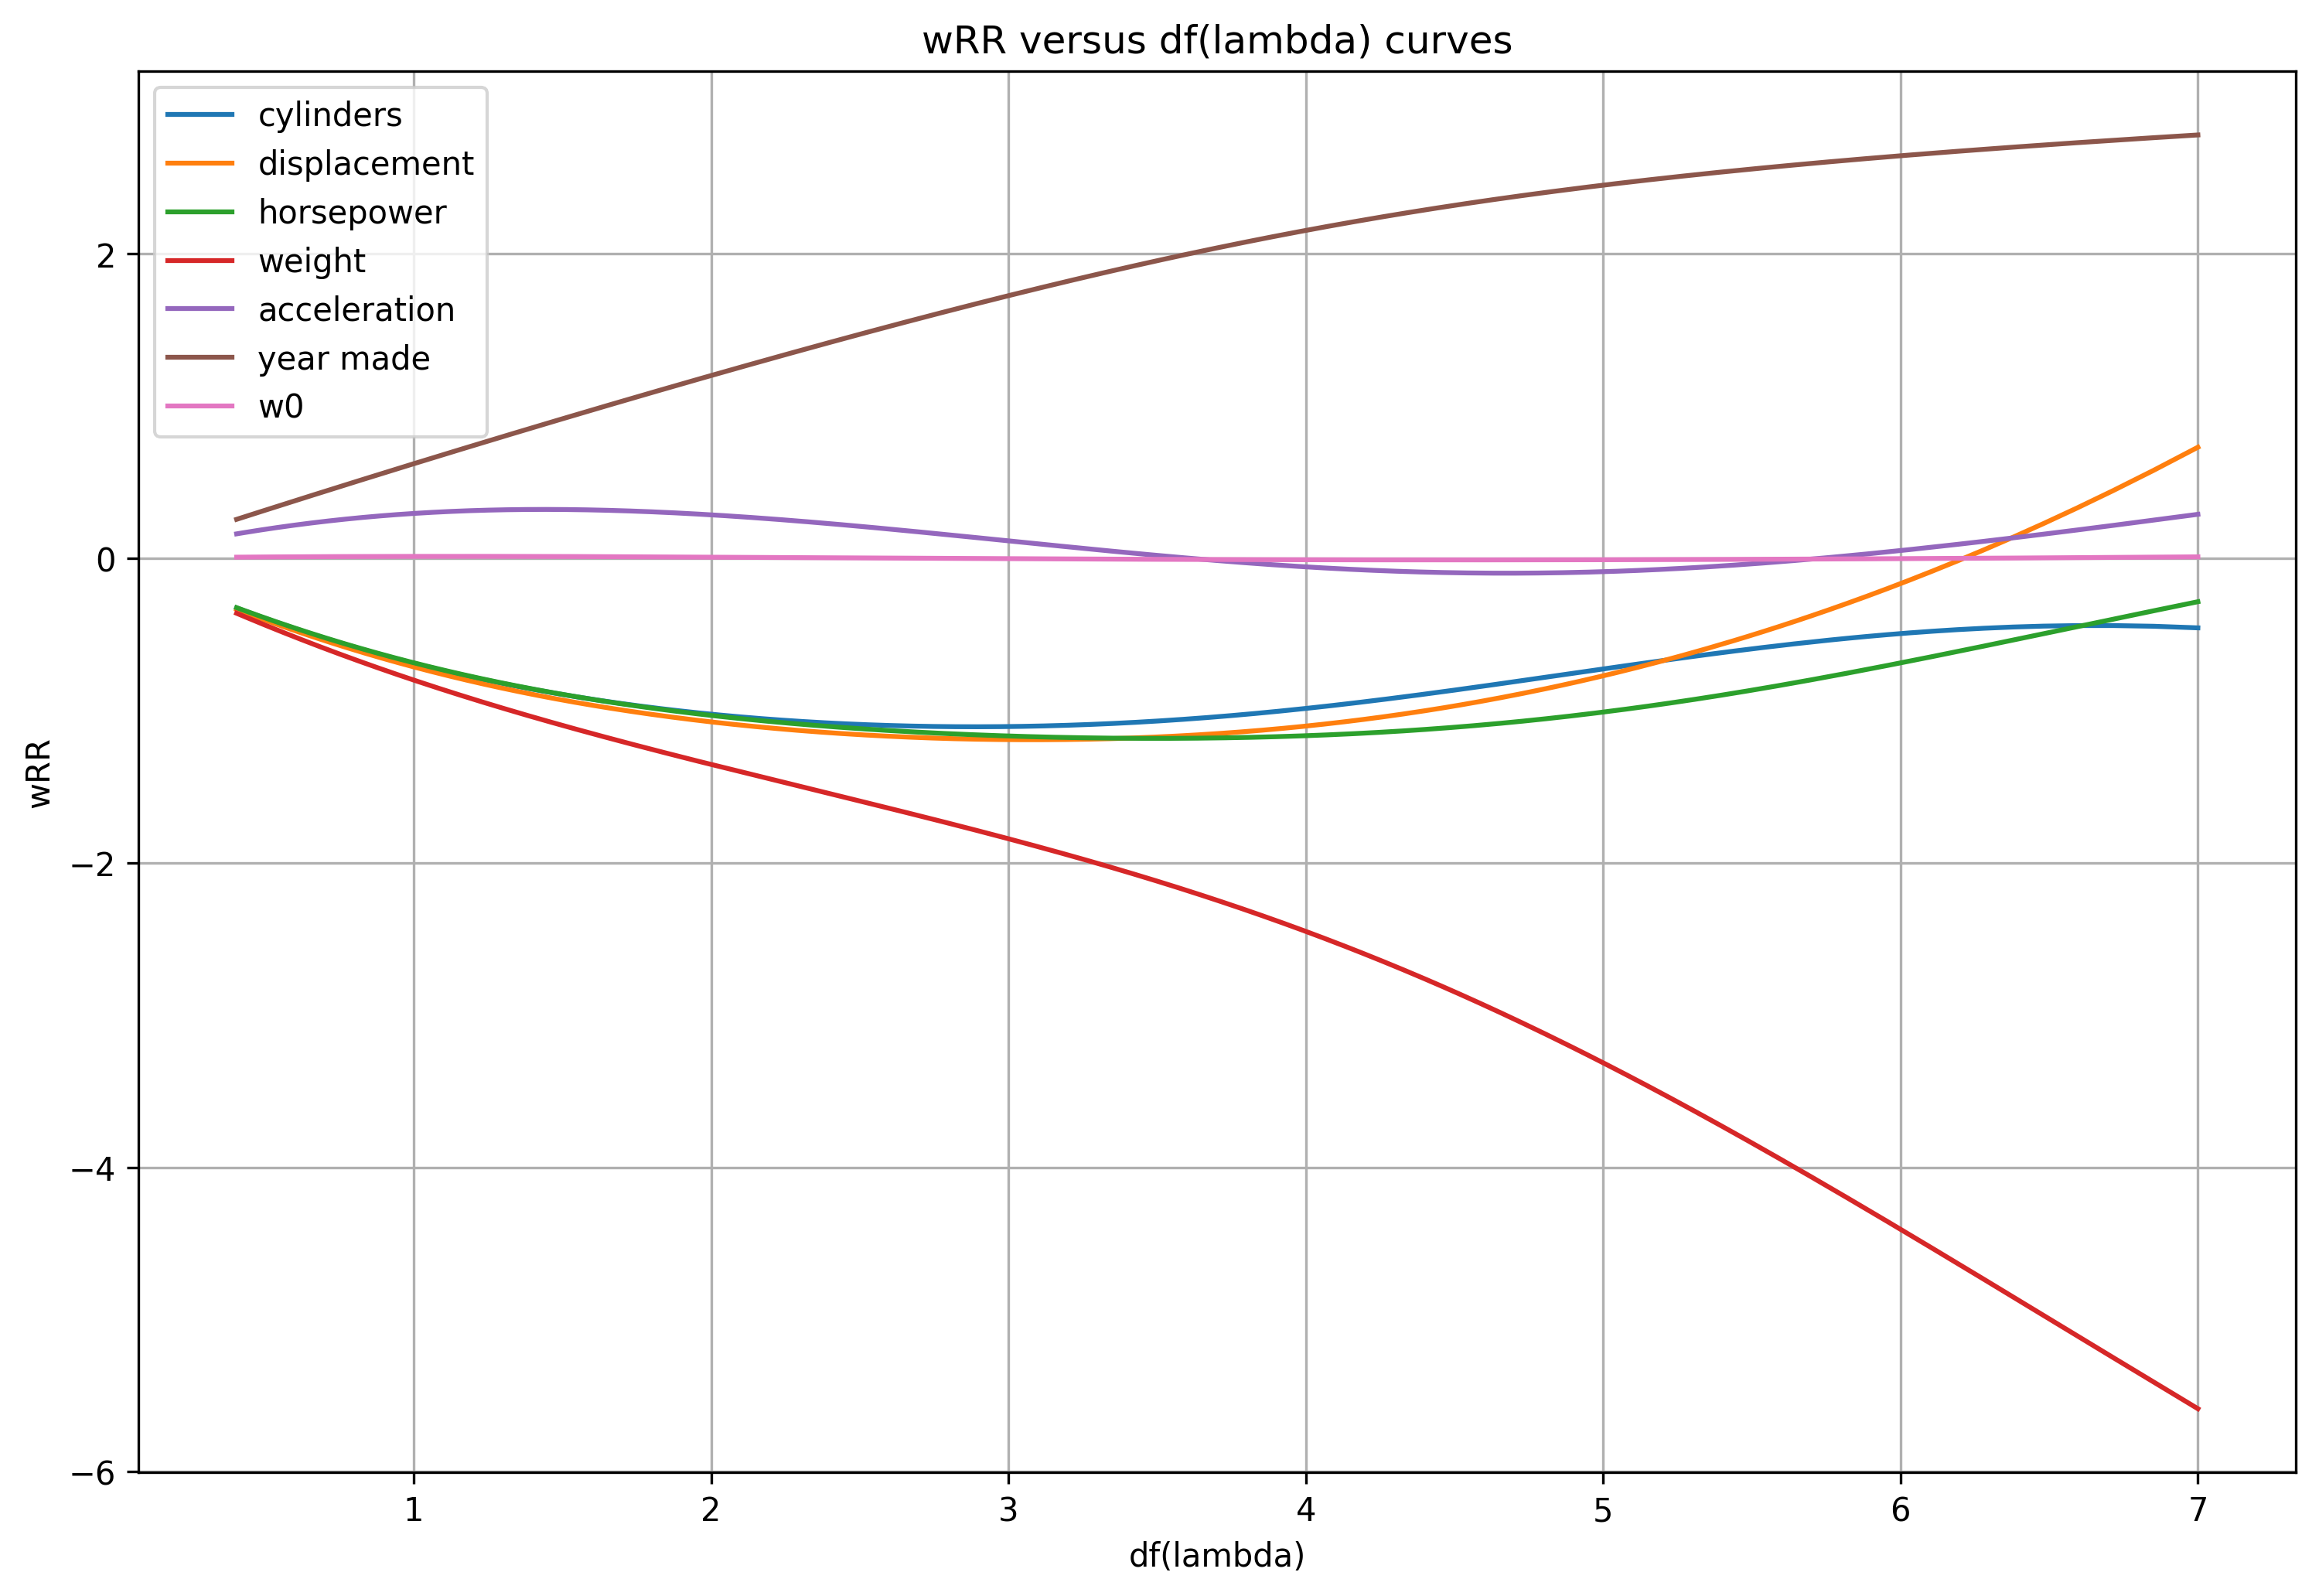

In [7]:
fig = plt.figure(figsize = (12, 8), dpi=300)
plt.grid()
plt.xlabel('df(lambda)')
plt.ylabel('wRR')
plt.title('wRR versus df(lambda) curves')
for i in range(7):
    plt.plot(df_lamb, wRR.T[i], label=label_dic[i])
plt.legend()
plt.savefig('wRR versus df(lambda) curves.png')

# Problem 3 - (c)

### get new wRR and prediction of y

In [8]:
lamb_max = 51
wRR_test = wRR[:lamb_max]
y_pred = X_test.dot(wRR_test.T)

### define RMSE calculation function

In [9]:
def RMSE(y_t, y_p):
    sum_delta = sum((y_t[c] - y_p[c]) ** 2 for c in range(42))
    sum_delta = np.sqrt(sum_delta / 42.0)
    return sum_delta

### get RMSE array

In [10]:
RMSE_list = np.zeros(lamb_max)
for lamb in range(lamb_max):
    RMSE_list[lamb] = RMSE(y_test.values, y_pred[lamb].values)

### plot RMSE versus lambda curves

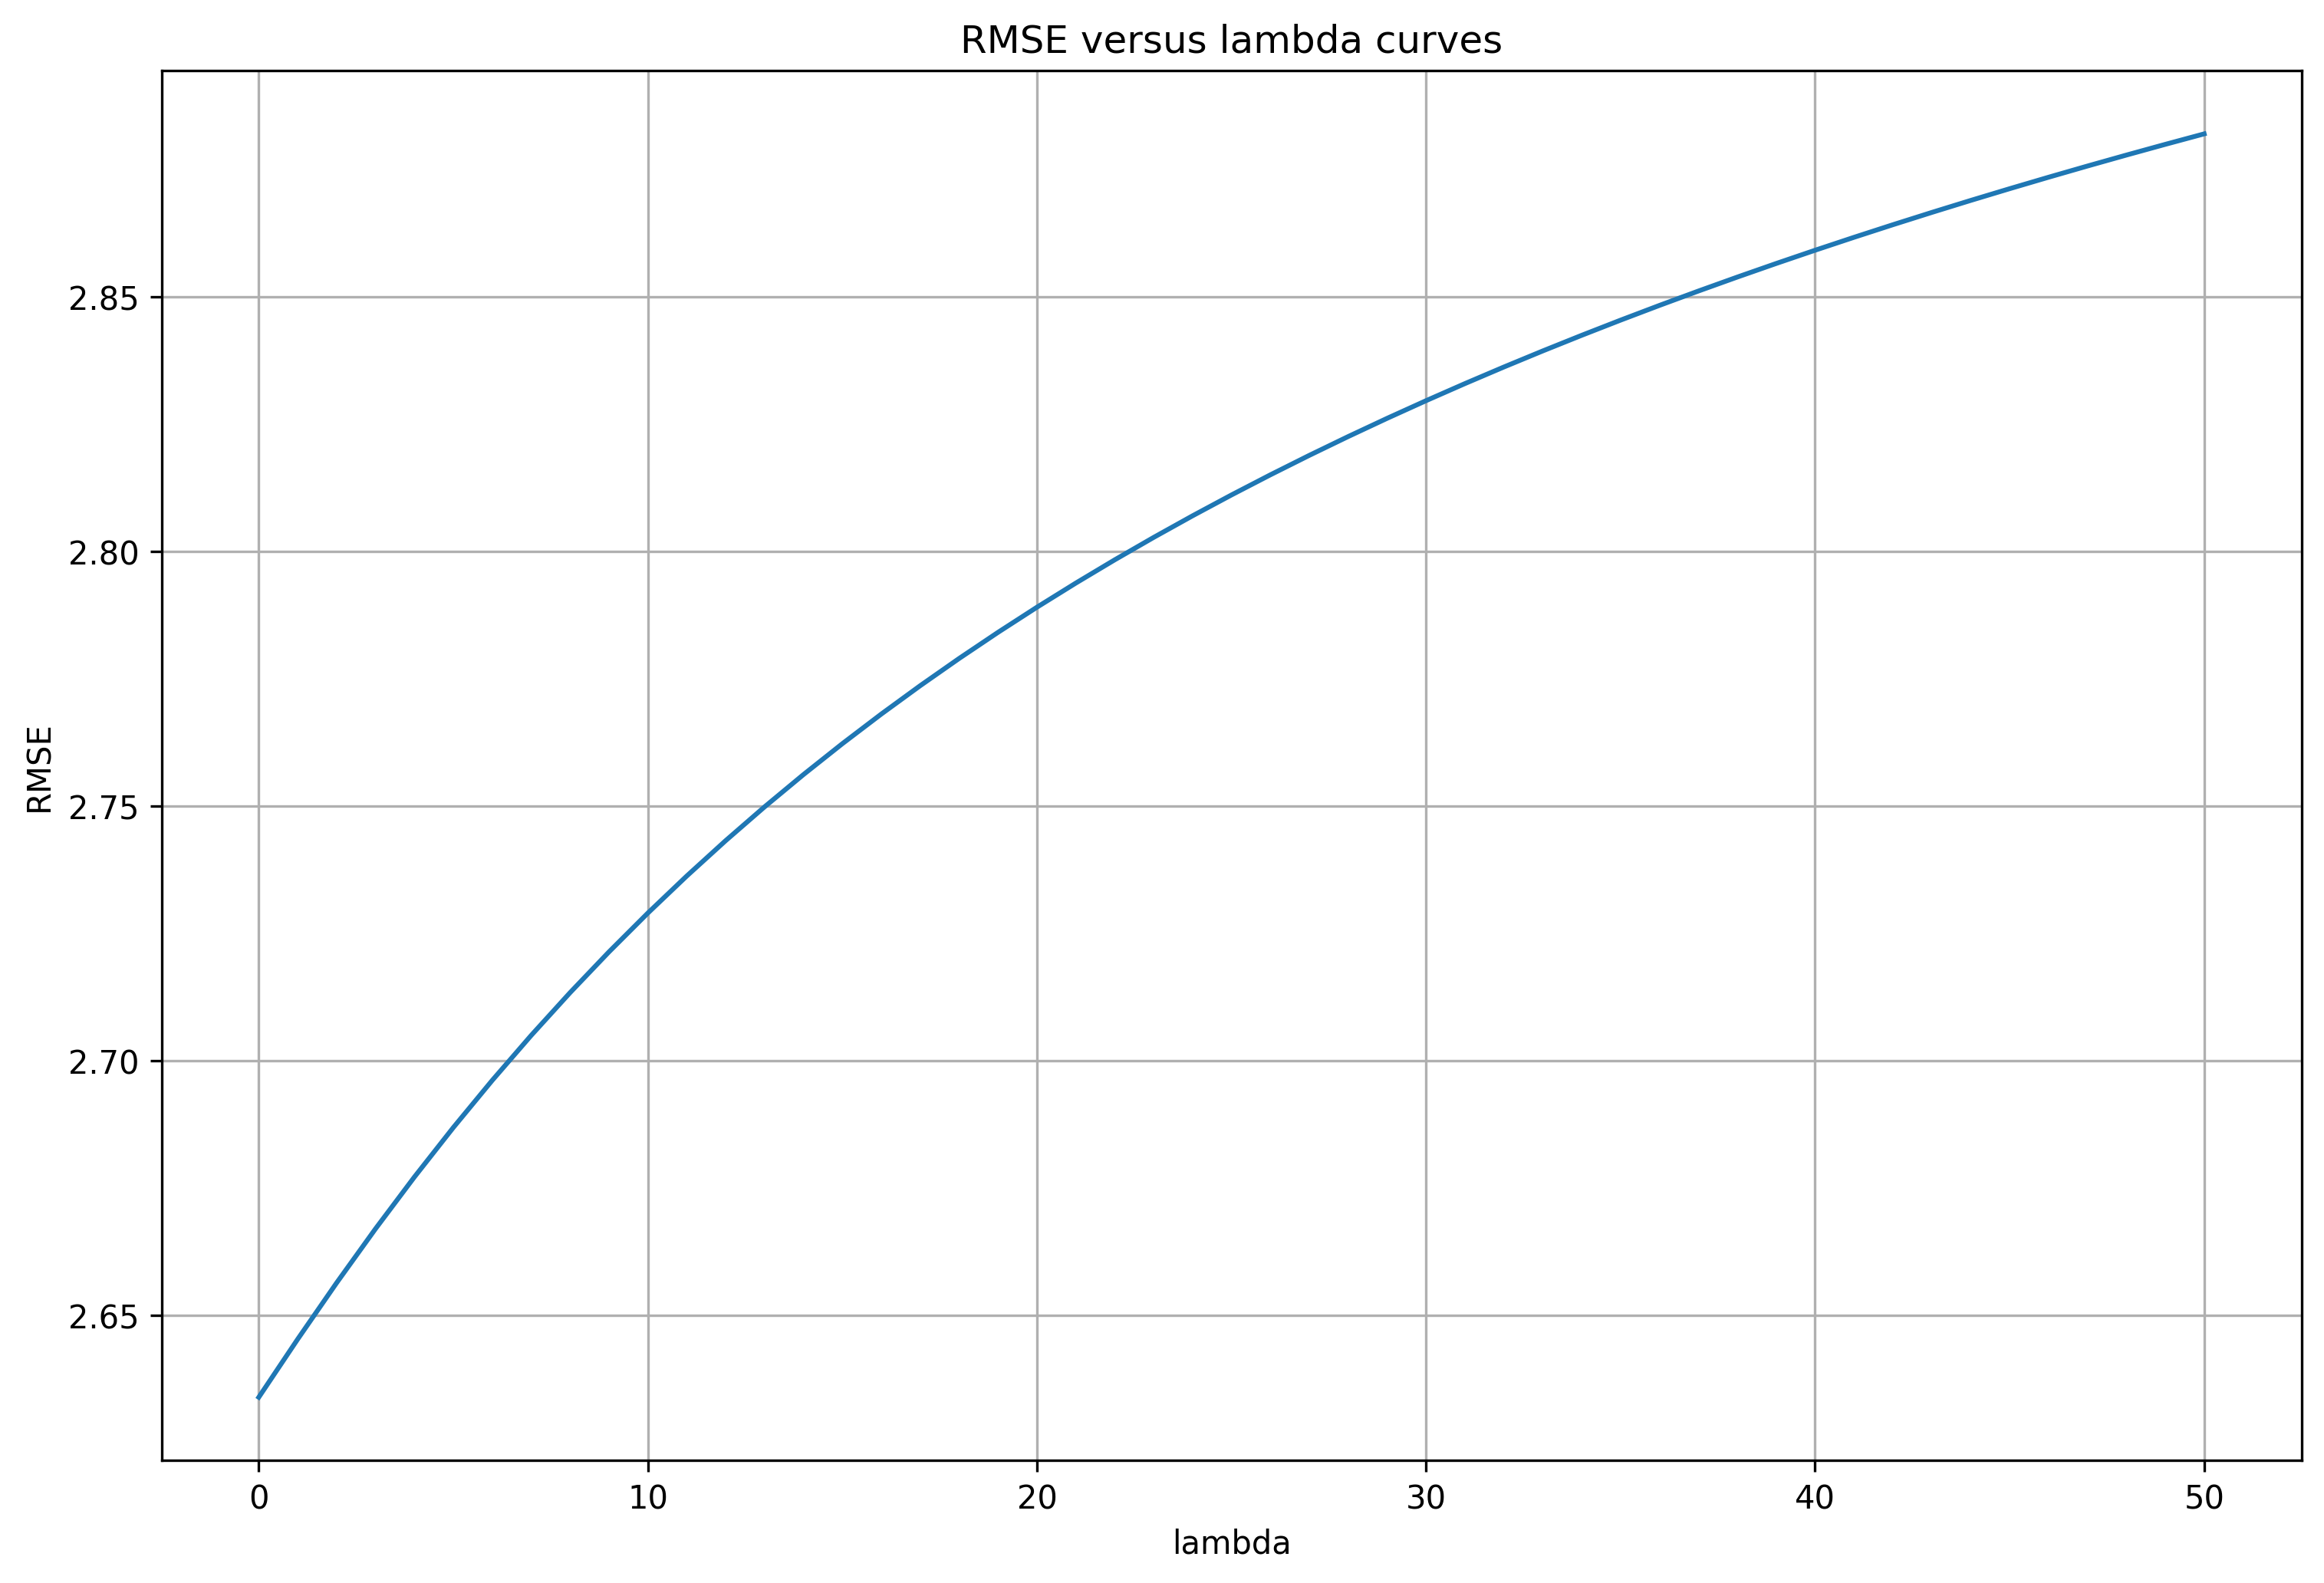

In [11]:
fig = plt.figure(figsize = (12, 8), dpi=300)
plt.grid()
plt.xlabel('lambda')
plt.ylabel('RMSE')
plt.title('RMSE versus lambda curves')
plt.plot(RMSE_list)
plt.savefig('RMSE versus lambda curves.png')

### Problem 3 - (d)

In [12]:
def process_data(data, p):
    """Preprocesses dataframe for p-polynomial regression.
    According to the instruction, added p-polynomial dimension requires standardization

    Args:
        data: input original dataframe.
        p: p-polynomial process.

    Returns:
        A dataframe with more dimensions which derive from polynomial process.
    """
    data = data[data.columns[:-1]] # delete the last all-1 column
    dt = [data]

    # get new data with p-polynomial process
    for i in range(2, p+1):
        data_i = data ** i
        for column in data_i.columns:
            data_i[column] = (data_i[column] - data_i[column].mean()) / data_i[column].std()
        data_i = data_i.rename(columns=lambda x: x + '^' + str(i))
        dt.append(data_i)
    dt = pd.concat(dt, axis=1)
    dt['w0'] = 1
        
    return dt

In [13]:
def get_RMSE(X_train, X_test, y_train, y_test, p, lamb_max):
    """Gets a list of RMSE versus lambda in p-polynomial condition.

    Args:
        X_train, ... , y_test: training and testing data.
        p: p-th polynomial process.
        lamb_max: the range of lambda.
        
    Return:
        RMSE lists.
    """
    # preprocess X data
    X_p = pd.concat([X_train, X_test], axis=0)
    X_p = process_data(X_p, p)
    X_train_p = X_p.iloc[:len(X_train)]
    X_test_p = X_p.iloc[-len(X_test):]

    dim_p = X_train_p.shape[1] # get the dimension of new training data
    wRR_p = []
    X = X_train_p.values
    
    # calculate wRR for each possible lambda
    for lamb in range(lamb_max):
        lambI = np.diag(np.ones(dim_p) * lamb)
        inv = np.linalg.inv(lambI + X.T.dot(X))
        wRR_p.append(inv.dot(X.T).dot(y_train.values).T[0])
    wRR_p = np.array(wRR_p)
    
    y_pred_p = X_test_p.dot(wRR_p.T) # get prediction of y, which is a function of lambda
    
    RMSE_list = np.zeros(lamb_max)
    
    for lamb in range(lamb_max):
        RMSE_list[lamb] = RMSE(y_test.values, y_pred_p[lamb].values)

    return RMSE_list

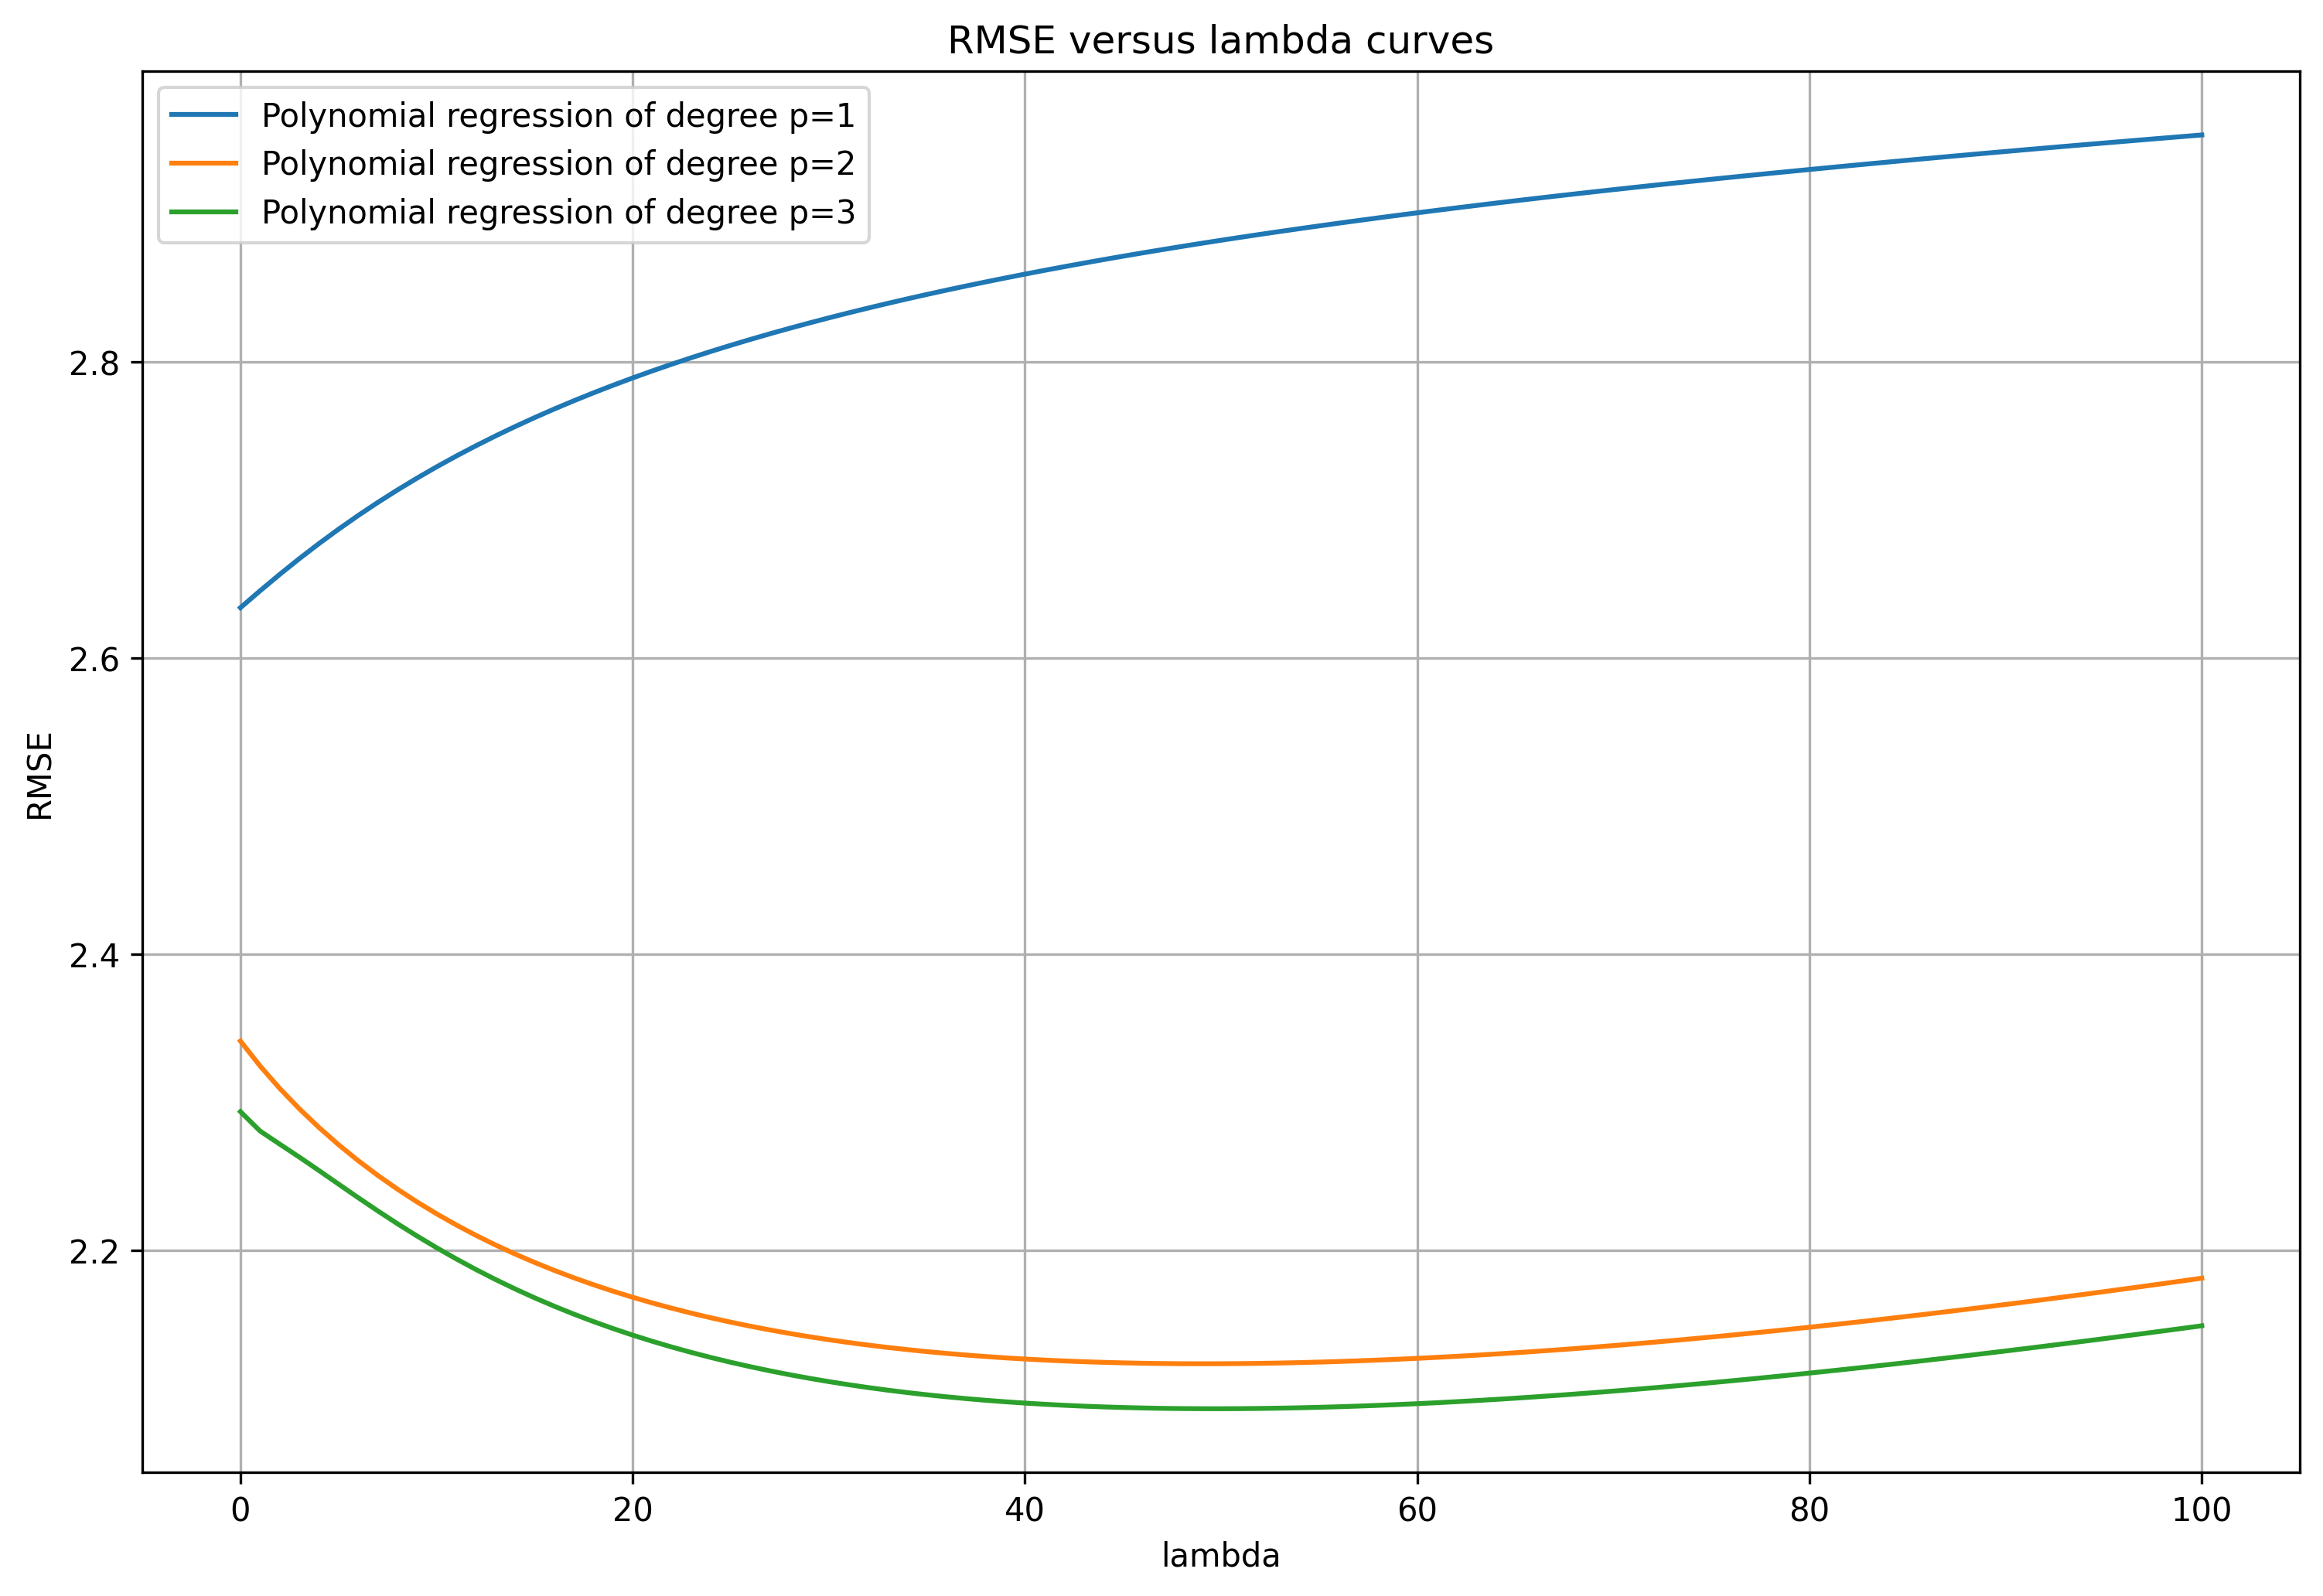

In [14]:
fig = plt.figure(figsize = (12, 8), dpi=300)
plt.grid()
plt.xlabel('lambda')
plt.ylabel('RMSE')
plt.title('RMSE versus lambda curves')
for p in range(1, 4):
    plot_RMSE = get_RMSE(X_train, X_test, y_train, y_test, p, 101)
    plt.plot(plot_RMSE, label='Polynomial regression of degree p=%d' % p)
plt.legend()
plt.savefig('RMSE versus lambda curves in polynomial regression.png')